In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install tensorpack

%cd gdrive/MyDrive/SEAI_Project

     |████████████████████████████████| 296kB 21.9MB/s 
/content/gdrive/MyDrive/SEAI_Project


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# File: svhn-digit-dorefa.py
# Author: Yuxin Wu

import argparse
import os
import tensorflow as tf

from tensorpack import *
from tensorpack.dataflow import dataset
from tensorpack.tfutils.summary import add_moving_summary, add_param_summary
from tensorpack.tfutils.varreplace import remap_variables

"""
This is a tensorpack script for the SVHN results in paper:
DoReFa-Net: Training Low Bitwidth Convolutional Neural Networks with Low Bitwidth Gradients
http://arxiv.org/abs/1606.06160
The original experiements are performed on a proprietary framework.
This is our attempt to reproduce it on tensorpack.
Accuracy:
    With (W,A,G)=(1,1,4), can reach 3.1~3.2% error after 150 epochs.
    With (W,A,G)=(1,2,4), error is 3.0~3.1%.
    With (W,A,G)=(32,32,32), error is about 2.3%.
Speed:
    With quantization, 60 batch/s on 1 1080Ti. (4721 batch / epoch)
To Run:
    ./svhn-digit-dorefa.py --dorefa 1,2,4
"""
tf.compat.v1.reset_default_graph()

BITW = 1
BITA = 2
BITG = 4

"""
imported from dorefa file
"""
def get_dorefa(bitW, bitA, bitG):
    """
    Return the three quantization functions fw, fa, fg, for weights, activations and gradients respectively
    """
    def quantize(x, k):
        n = float(2 ** k - 1)

        @tf.custom_gradient
        def _quantize(x):
            return tf.round(x * n) / n, lambda dy: dy

        return _quantize(x)

    def fw(x):
        if bitW == 32:
            return x

        if bitW == 1:   # BWN
            E = tf.stop_gradient(tf.reduce_mean(tf.abs(x)))

            @tf.custom_gradient
            def _sign(x):
                return tf.where(tf.equal(x, 0), tf.ones_like(x), tf.sign(x / E)) * E, lambda dy: dy

            return _sign(x)

        x = tf.tanh(x)
        x = x / tf.reduce_max(tf.abs(x)) * 0.5 + 0.5
        return 2 * quantize(x, bitW) - 1

    def fa(x):
        if bitA == 32:
            return x
        return quantize(x, bitA)

    def fg(x):
        if bitG == 32:
            return x

        @tf.custom_gradient
        def _identity(input):
            def grad_fg(x):
                rank = x.get_shape().ndims
                assert rank is not None
                maxx = tf.reduce_max(tf.abs(x), list(range(1, rank)), keepdims=True)
                x = x / maxx
                n = float(2**bitG - 1)
                x = x * 0.5 + 0.5 + tf.random.uniform(
                    tf.shape(x), minval=-0.5 / n, maxval=0.5 / n)
                x = tf.clip_by_value(x, 0.0, 1.0)
                x = quantize(x, bitG) - 0.5
                return x * maxx * 2

            return input, grad_fg

        return _identity(x)
    return fw, fa, fg


class Model(ModelDesc):
    def inputs(self):
        return [tf.TensorSpec([None, 40, 40, 3], tf.float32, 'input'),
                tf.TensorSpec([None], tf.int32, 'label')]

    def build_graph(self, image, label):
        fw, fa, fg = get_dorefa(BITW, BITA, BITG)

        # monkey-patch tf.get_variable to apply fw
        def binarize_weight(v):
            name = v.op.name
            # don't binarize first and last layer
            if not name.endswith('W') or 'conv0' in name or 'fc' in name:
                return v
            else:
                logger.info("Binarizing weight {}".format(v.op.name))
                return fw(v)

        def nonlin(x):
            if BITA == 32:
                return tf.nn.relu(x)
            return tf.clip_by_value(x, 0.0, 1.0)

        def activate(x):
            return fa(nonlin(x))

        image = image / 256.0

        with remap_variables(binarize_weight), \
                argscope(BatchNorm, momentum=0.9, epsilon=1e-4), \
                argscope(Conv2D, use_bias=False):
            logits = (LinearWrap(image)
                      .Conv2D('conv0', 48, 5, padding='VALID', use_bias=True)
                      .MaxPooling('pool0', 2, padding='SAME')
                      .apply(activate)
                      # 18
                      .Conv2D('conv1', 64, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn1').apply(activate)
#AVGPooling
                      .Conv2D('conv2', 64, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn2')
                      .MaxPooling('pool1', 2, padding='SAME')
                      .apply(activate)
                      # 9
                      .Conv2D('conv3', 128, 3, padding='VALID')
                      .apply(fg)
                      .BatchNorm('bn3').apply(activate)
                      # 7

                      .Conv2D('conv4', 128, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn4').apply(activate)

                      .Conv2D('conv5', 128, 3, padding='VALID')
                      .apply(fg)
                      .BatchNorm('bn5').apply(activate)
                      # 5
                      .Dropout(rate=0.5 if self.training else 0.0)
                      .Conv2D('conv6', 512, 5, padding='VALID')
                      .apply(fg).BatchNorm('bn6')
                      .apply(nonlin)
                      .FullyConnected('fc1', 10)())
        tf.nn.softmax(logits, name='output')

        correct = tf.cast(tf.nn.in_top_k(predictions=logits, targets=label, k=1), tf.float32, name='correct')
        accuracy = tf.reduce_mean(correct, name='accuracy')
        train_error = tf.reduce_mean(1 - correct, name='train_error')
        summary.add_moving_summary(train_error, accuracy)
        
        cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        cost = tf.reduce_mean(cost, name='cross_entropy_loss')
        # weight decay on all W of fc layers
        wd_cost = regularize_cost('fc.*/W', l2_regularizer(1e-7))
        add_param_summary(('.*/W', ['histogram', 'rms']))
        total_cost = tf.add_n([cost, wd_cost], name='cost')
        add_moving_summary(cost, wd_cost, total_cost)
        return total_cost

    def optimizer(self):
        lr = tf.compat.v1.train.exponential_decay(
            learning_rate=1e-3,
            global_step=get_global_step_var(),
            decay_steps=4721 * 100,
            decay_rate=0.5, staircase=True, name='learning_rate')
        tf.summary.scalar('lr', lr)

        return tf.compat.v1.train.AdamOptimizer(lr, epsilon=1e-5)


def get_config():
    logger.set_logger_dir(os.path.join('train_log', 'svhn-dorefa-{}'.format(args)))

    # prepare dataset
    d1 = dataset.SVHNDigit('train')
    d2 = dataset.SVHNDigit('extra')
    data_train = RandomMixData([d1, d2])
    data_test = dataset.SVHNDigit('test')

    augmentors = [
        imgaug.Resize((40, 40)),
        imgaug.Brightness(30),
        imgaug.Contrast((0.5, 1.5)),
    ]
    data_train = AugmentImageComponent(data_train, augmentors)
    data_train = BatchData(data_train, 128)
    data_train = MultiProcessRunnerZMQ(data_train, 5)

    augmentors = [imgaug.Resize((40, 40))]
    data_test = AugmentImageComponent(data_test, augmentors)
    data_test = BatchData(data_test, 128, remainder=True)

    return TrainConfig(
        data=QueueInput(data_train),
        callbacks=[
            ModelSaver(),
            InferenceRunner(    # run inference(for validation) after every epoch
                data_test,   # the DataFlow instance used for validation
                ScalarStats(    # produce `val_accuracy` and `val_cross_entropy_loss`
                    ['cross_entropy_loss', 'accuracy'], prefix='val'))
        ],
        model=Model(),
        max_epoch=10,
    )

args = "1,2,4"
BITW, BITA, BITG = map(int, args.split(','))
config = get_config()
launch_train_with_config(config, SimpleTrainer())

'''
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dorefa',
                        help='number of bits for W,A,G, separated by comma. Defaults to \'1,2,4\'',
                        default='1,2,4')
    args = parser.parse_args()

    BITW, BITA, BITG = map(int, args.dorefa.split(','))
    config = get_config()
    launch_train_with_config(config, SimpleTrainer())
'''

[0715 14:02:40 @logger.py:128] WRN Log directory train_log/svhn-dorefa-1,2,4 exists! Use 'd' to delete it. 
[0715 14:02:40 @logger.py:131] WRN If you're resuming from a previous run, you can choose to keep it.
Press any other key to exit. 
[0715 14:02:42 @logger.py:85] Existing log file 'train_log/svhn-dorefa-1,2,4/log.log' backuped to 'train_log/svhn-dorefa-1,2,4/log.log.0715-140242'
[0715 14:02:42 @logger.py:92] Argv: /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-49d3f7f6-7d8c-4bc8-ae1e-7863be7d26fe.json
[0715 14:02:42 @parallel.py:340] [MultiProcessRunnerZMQ] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
[0715 14:02:42 @input_source.py:221] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[0715 14:02:43 @trainers.py:48] Building graph for a single training tower ...
[0715 14:02:43 @<ipython-input-17-200335a6510d>:113] Binarizing weight conv1/W
[0715 14:02:43 @<ipython-

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


[0715 14:02:43 @<ipython-input-17-200335a6510d>:113] Binarizing weight conv4/W
[0715 14:02:43 @<ipython-input-17-200335a6510d>:113] Binarizing weight conv5/W
[0715 14:02:43 @<ipython-input-17-200335a6510d>:113] Binarizing weight conv6/W
[0715 14:02:43 @regularize.py:97] regularize_cost() found 1 variables to regularize.
[0715 14:02:43 @regularize.py:21] The following tensors will be regularized: fc1/W:0
[0715 14:02:44 @model_utils.py:67] List of Trainable Variables: 
name       shape               #elements
---------  ----------------  -----------
conv0/W    [5, 5, 3, 48]            3600
conv0/b    [48]                       48
conv1/W    [3, 3, 48, 64]          27648
bn1/gamma  [64]                       64
bn1/beta   [64]                       64
conv2/W    [3, 3, 64, 64]          36864
bn2/gamma  [64]                       64
bn2/beta   [64]                       64
conv3/W    [3, 3, 64, 128]         73728
bn3/gamma  [128]                     128
bn3/beta   [128]                    

100%|##########|4721/4721[05:10<00:00,15.19it/s]

[0715 14:08:00 @base.py:283] Epoch 1 (global_step 4721) finished, time:5 minutes 10 seconds.


[0715 14:08:00 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-4721.


100%|##########|204/204[00:12<00:00,15.93it/s]

[0715 14:08:13 @monitor.py:476] QueueInput/queue_size: 19
[0715 14:08:13 @monitor.py:476] accuracy: 0.95088
[0715 14:08:13 @monitor.py:476] cost: 0.1655
[0715 14:08:13 @monitor.py:476] cross_entropy_loss: 0.1655
[0715 14:08:13 @monitor.py:476] param-summary/conv0/W-rms: 0.17576
[0715 14:08:13 @monitor.py:476] param-summary/conv1/W-rms: 0.078577
[0715 14:08:13 @monitor.py:476] param-summary/conv2/W-rms: 0.071168
[0715 14:08:13 @monitor.py:476] param-summary/conv3/W-rms: 0.074478
[0715 14:08:13 @monitor.py:476] param-summary/conv4/W-rms: 0.062045
[0715 14:08:13 @monitor.py:476] param-summary/conv5/W-rms: 0.065983
[0715 14:08:13 @monitor.py:476] param-summary/conv6/W-rms: 0.052521
[0715 14:08:13 @monitor.py:476] param-summary/fc1/W-rms: 0.10409
[0715 14:08:13 @monitor.py:476] regularize_cost: 2.7634e-06
[0715 14:08:13 @monitor.py:476] train_error: 0.049122
[0715 14:08:13 @monitor.py:476] val_accuracy: 0.92184
[0715 14:08:13 @monitor.py:476] val_cross_entropy_loss: 0.2737
[0715 14:08:13 @g


100%|##########|4721/4721[04:50<00:00,16.24it/s]

[0715 14:13:04 @base.py:283] Epoch 2 (global_step 9442) finished, time:4 minutes 50 seconds.


[0715 14:13:04 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-9442.


100%|##########|204/204[00:12<00:00,16.85it/s]

[0715 14:13:16 @monitor.py:476] QueueInput/queue_size: 0.55469
[0715 14:13:16 @monitor.py:476] accuracy: 0.9615
[0715 14:13:16 @monitor.py:476] cost: 0.1334
[0715 14:13:16 @monitor.py:476] cross_entropy_loss: 0.13339
[0715 14:13:16 @monitor.py:476] param-summary/conv0/W-rms: 0.19275
[0715 14:13:16 @monitor.py:476] param-summary/conv1/W-rms: 0.093796
[0715 14:13:16 @monitor.py:476] param-summary/conv2/W-rms: 0.092398
[0715 14:13:16 @monitor.py:476] param-summary/conv3/W-rms: 0.097813
[0715 14:13:16 @monitor.py:476] param-summary/conv4/W-rms: 0.087621
[0715 14:13:16 @monitor.py:476] param-summary/conv5/W-rms: 0.091966
[0715 14:13:16 @monitor.py:476] param-summary/conv6/W-rms: 0.078654
[0715 14:13:16 @monitor.py:476] param-summary/fc1/W-rms: 0.12801
[0715 14:13:16 @monitor.py:476] regularize_cost: 4.1913e-06
[0715 14:13:16 @monitor.py:476] train_error: 0.038498
[0715 14:13:16 @monitor.py:476] val_accuracy: 0.93879
[0715 14:13:16 @monitor.py:476] val_cross_entropy_loss: 0.21328
[0715 14:13


100%|##########|4721/4721[04:52<00:00,16.16it/s]

[0715 14:18:09 @base.py:283] Epoch 3 (global_step 14163) finished, time:4 minutes 52 seconds.
[0715 14:18:09 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-14163.



100%|##########|204/204[00:12<00:00,16.73it/s]

[0715 14:18:21 @monitor.py:476] QueueInput/queue_size: 3.2588e-30
[0715 14:18:21 @monitor.py:476] accuracy: 0.97266
[0715 14:18:21 @monitor.py:476] cost: 0.097908
[0715 14:18:21 @monitor.py:476] cross_entropy_loss: 0.097902
[0715 14:18:21 @monitor.py:476] param-summary/conv0/W-rms: 0.21286
[0715 14:18:21 @monitor.py:476] param-summary/conv1/W-rms: 0.11218
[0715 14:18:21 @monitor.py:476] param-summary/conv2/W-rms: 0.1134
[0715 14:18:21 @monitor.py:476] param-summary/conv3/W-rms: 0.12164
[0715 14:18:21 @monitor.py:476] param-summary/conv4/W-rms: 0.11177
[0715 14:18:21 @monitor.py:476] param-summary/conv5/W-rms: 0.11602
[0715 14:18:21 @monitor.py:476] param-summary/conv6/W-rms: 0.10088
[0715 14:18:21 @monitor.py:476] param-summary/fc1/W-rms: 0.14532
[0715 14:18:21 @monitor.py:476] regularize_cost: 5.3996e-06
[0715 14:18:21 @monitor.py:476] train_error: 0.027341
[0715 14:18:21 @monitor.py:476] val_accuracy: 0.95144
[0715 14:18:21 @monitor.py:476] val_cross_entropy_loss: 0.18067
[0715 14:18


100%|##########|4721/4721[04:52<00:00,16.15it/s]

[0715 14:23:14 @base.py:283] Epoch 4 (global_step 18884) finished, time:4 minutes 52 seconds.


[0715 14:23:14 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-18884.


100%|##########|204/204[00:11<00:00,17.00it/s]

[0715 14:23:26 @monitor.py:476] QueueInput/queue_size: 3.4925e-10
[0715 14:23:26 @monitor.py:476] accuracy: 0.97083
[0715 14:23:26 @monitor.py:476] cost: 0.10469
[0715 14:23:26 @monitor.py:476] cross_entropy_loss: 0.10469
[0715 14:23:26 @monitor.py:476] param-summary/conv0/W-rms: 0.23129
[0715 14:23:26 @monitor.py:476] param-summary/conv1/W-rms: 0.1311
[0715 14:23:26 @monitor.py:476] param-summary/conv2/W-rms: 0.13496
[0715 14:23:26 @monitor.py:476] param-summary/conv3/W-rms: 0.1417
[0715 14:23:26 @monitor.py:476] param-summary/conv4/W-rms: 0.13243
[0715 14:23:26 @monitor.py:476] param-summary/conv5/W-rms: 0.13764
[0715 14:23:26 @monitor.py:476] param-summary/conv6/W-rms: 0.11945
[0715 14:23:26 @monitor.py:476] param-summary/fc1/W-rms: 0.15858
[0715 14:23:26 @monitor.py:476] regularize_cost: 6.4354e-06
[0715 14:23:26 @monitor.py:476] train_error: 0.029169
[0715 14:23:26 @monitor.py:476] val_accuracy: 0.95287
[0715 14:23:26 @monitor.py:476] val_cross_entropy_loss: 0.17245
[0715 14:23:26


100%|##########|4721/4721[04:55<00:00,15.96it/s]

[0715 14:28:22 @base.py:283] Epoch 5 (global_step 23605) finished, time:4 minutes 55 seconds.


[0715 14:28:22 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-23605.


100%|##########|204/204[00:11<00:00,17.80it/s]

[0715 14:28:33 @monitor.py:476] QueueInput/queue_size: 1.3531e-26
[0715 14:28:33 @monitor.py:476] accuracy: 0.97286
[0715 14:28:33 @monitor.py:476] cost: 0.09501
[0715 14:28:33 @monitor.py:476] cross_entropy_loss: 0.095002
[0715 14:28:33 @monitor.py:476] param-summary/conv0/W-rms: 0.24888
[0715 14:28:33 @monitor.py:476] param-summary/conv1/W-rms: 0.14511
[0715 14:28:33 @monitor.py:476] param-summary/conv2/W-rms: 0.15052
[0715 14:28:33 @monitor.py:476] param-summary/conv3/W-rms: 0.16046
[0715 14:28:33 @monitor.py:476] param-summary/conv4/W-rms: 0.1509
[0715 14:28:33 @monitor.py:476] param-summary/conv5/W-rms: 0.15718
[0715 14:28:33 @monitor.py:476] param-summary/conv6/W-rms: 0.13557
[0715 14:28:33 @monitor.py:476] param-summary/fc1/W-rms: 0.17182
[0715 14:28:33 @monitor.py:476] regularize_cost: 7.5527e-06
[0715 14:28:33 @monitor.py:476] train_error: 0.027136
[0715 14:28:33 @monitor.py:476] val_accuracy: 0.95412
[0715 14:28:33 @monitor.py:476] val_cross_entropy_loss: 0.16857
[0715 14:28:


100%|##########|4721/4721[05:00<00:00,15.74it/s]

[0715 14:33:33 @base.py:283] Epoch 6 (global_step 28326) finished, time:5 minutes.
[0715 14:33:34 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-28326.



100%|##########|204/204[00:12<00:00,16.54it/s]

[0715 14:33:46 @monitor.py:476] QueueInput/queue_size: 7.1395e-17
[0715 14:33:46 @monitor.py:476] accuracy: 0.97992
[0715 14:33:46 @monitor.py:476] cost: 0.078589
[0715 14:33:46 @monitor.py:476] cross_entropy_loss: 0.07858
[0715 14:33:46 @monitor.py:476] param-summary/conv0/W-rms: 0.25885
[0715 14:33:46 @monitor.py:476] param-summary/conv1/W-rms: 0.15598
[0715 14:33:46 @monitor.py:476] param-summary/conv2/W-rms: 0.16919
[0715 14:33:46 @monitor.py:476] param-summary/conv3/W-rms: 0.17897
[0715 14:33:46 @monitor.py:476] param-summary/conv4/W-rms: 0.16855
[0715 14:33:46 @monitor.py:476] param-summary/conv5/W-rms: 0.17577
[0715 14:33:46 @monitor.py:476] param-summary/conv6/W-rms: 0.15025
[0715 14:33:46 @monitor.py:476] param-summary/fc1/W-rms: 0.18472
[0715 14:33:46 @monitor.py:476] regularize_cost: 8.7312e-06
[0715 14:33:46 @monitor.py:476] train_error: 0.020084
[0715 14:33:46 @monitor.py:476] val_accuracy: 0.96041
[0715 14:33:46 @monitor.py:476] val_cross_entropy_loss: 0.1527
[0715 14:33:


100%|##########|4721/4721[04:53<00:00,16.08it/s]

[0715 14:38:40 @base.py:283] Epoch 7 (global_step 33047) finished, time:4 minutes 53 seconds.


[0715 14:38:40 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-33047.


100%|##########|204/204[00:11<00:00,17.09it/s]

[0715 14:38:52 @monitor.py:476] QueueInput/queue_size: 1.0333
[0715 14:38:52 @monitor.py:476] accuracy: 0.97614
[0715 14:38:52 @monitor.py:476] cost: 0.082807
[0715 14:38:52 @monitor.py:476] cross_entropy_loss: 0.082797
[0715 14:38:52 @monitor.py:476] param-summary/conv0/W-rms: 0.25992
[0715 14:38:52 @monitor.py:476] param-summary/conv1/W-rms: 0.17084
[0715 14:38:52 @monitor.py:476] param-summary/conv2/W-rms: 0.18559
[0715 14:38:52 @monitor.py:476] param-summary/conv3/W-rms: 0.19525
[0715 14:38:52 @monitor.py:476] param-summary/conv4/W-rms: 0.18425
[0715 14:38:52 @monitor.py:476] param-summary/conv5/W-rms: 0.19197
[0715 14:38:52 @monitor.py:476] param-summary/conv6/W-rms: 0.16357
[0715 14:38:52 @monitor.py:476] param-summary/fc1/W-rms: 0.1973
[0715 14:38:52 @monitor.py:476] regularize_cost: 9.9643e-06
[0715 14:38:52 @monitor.py:476] train_error: 0.023864
[0715 14:38:52 @monitor.py:476] val_accuracy: 0.96126
[0715 14:38:52 @monitor.py:476] val_cross_entropy_loss: 0.14981
[0715 14:38:52 


100%|##########|4721/4721[04:51<00:00,16.22it/s]

[0715 14:43:43 @base.py:283] Epoch 8 (global_step 37768) finished, time:4 minutes 51 seconds.


[0715 14:43:44 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-37768.


100%|##########|204/204[00:12<00:00,16.87it/s]

[0715 14:43:56 @monitor.py:476] QueueInput/queue_size: 3.0734e-08
[0715 14:43:56 @monitor.py:476] accuracy: 0.97682
[0715 14:43:56 @monitor.py:476] cost: 0.076374
[0715 14:43:56 @monitor.py:476] cross_entropy_loss: 0.076363
[0715 14:43:56 @monitor.py:476] param-summary/conv0/W-rms: 0.26822
[0715 14:43:56 @monitor.py:476] param-summary/conv1/W-rms: 0.18218
[0715 14:43:56 @monitor.py:476] param-summary/conv2/W-rms: 0.19986
[0715 14:43:56 @monitor.py:476] param-summary/conv3/W-rms: 0.21233
[0715 14:43:56 @monitor.py:476] param-summary/conv4/W-rms: 0.19969
[0715 14:43:56 @monitor.py:476] param-summary/conv5/W-rms: 0.2076
[0715 14:43:56 @monitor.py:476] param-summary/conv6/W-rms: 0.17607
[0715 14:43:56 @monitor.py:476] param-summary/fc1/W-rms: 0.20764
[0715 14:43:56 @monitor.py:476] regularize_cost: 1.1025e-05
[0715 14:43:56 @monitor.py:476] train_error: 0.023177
[0715 14:43:56 @monitor.py:476] val_accuracy: 0.96292
[0715 14:43:56 @monitor.py:476] val_cross_entropy_loss: 0.14542
[0715 14:43


100%|##########|4721/4721[04:53<00:00,16.11it/s]

[0715 14:48:49 @base.py:283] Epoch 9 (global_step 42489) finished, time:4 minutes 53 seconds.
[0715 14:48:49 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-42489.



100%|##########|204/204[00:11<00:00,17.05it/s]

[0715 14:49:01 @monitor.py:476] QueueInput/queue_size: 1.1921e-07
[0715 14:49:01 @monitor.py:476] accuracy: 0.98016
[0715 14:49:01 @monitor.py:476] cost: 0.06972
[0715 14:49:01 @monitor.py:476] cross_entropy_loss: 0.069708
[0715 14:49:01 @monitor.py:476] param-summary/conv0/W-rms: 0.27201
[0715 14:49:01 @monitor.py:476] param-summary/conv1/W-rms: 0.19127
[0715 14:49:01 @monitor.py:476] param-summary/conv2/W-rms: 0.21264
[0715 14:49:01 @monitor.py:476] param-summary/conv3/W-rms: 0.22677
[0715 14:49:01 @monitor.py:476] param-summary/conv4/W-rms: 0.2136
[0715 14:49:01 @monitor.py:476] param-summary/conv5/W-rms: 0.22198
[0715 14:49:01 @monitor.py:476] param-summary/conv6/W-rms: 0.18778
[0715 14:49:01 @monitor.py:476] param-summary/fc1/W-rms: 0.21807
[0715 14:49:01 @monitor.py:476] regularize_cost: 1.2162e-05
[0715 14:49:01 @monitor.py:476] train_error: 0.01984
[0715 14:49:01 @monitor.py:476] val_accuracy: 0.96205
[0715 14:49:01 @monitor.py:476] val_cross_entropy_loss: 0.14428
[0715 14:49:0


100%|##########|4721/4721[04:58<00:00,15.81it/s]

[0715 14:54:00 @base.py:283] Epoch 10 (global_step 47210) finished, time:4 minutes 58 seconds.


[0715 14:54:00 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-47210.


100%|##########|204/204[00:11<00:00,17.70it/s]

[0715 14:54:12 @monitor.py:476] QueueInput/queue_size: 0.78424
[0715 14:54:12 @monitor.py:476] accuracy: 0.97947
[0715 14:54:12 @monitor.py:476] cost: 0.083818
[0715 14:54:12 @monitor.py:476] cross_entropy_loss: 0.083805
[0715 14:54:12 @monitor.py:476] param-summary/conv0/W-rms: 0.27628
[0715 14:54:12 @monitor.py:476] param-summary/conv1/W-rms: 0.20369
[0715 14:54:12 @monitor.py:476] param-summary/conv2/W-rms: 0.22813
[0715 14:54:12 @monitor.py:476] param-summary/conv3/W-rms: 0.24078
[0715 14:54:12 @monitor.py:476] param-summary/conv4/W-rms: 0.22698


[0715 14:54:12 @monitor.py:476] param-summary/conv5/W-rms: 0.23608
[0715 14:54:12 @monitor.py:476] param-summary/conv6/W-rms: 0.19868
[0715 14:54:12 @monitor.py:476] param-summary/fc1/W-rms: 0.22823
[0715 14:54:12 @monitor.py:476] regularize_cost: 1.334e-05
[0715 14:54:12 @monitor.py:476] train_error: 0.020529
[0715 14:54:12 @monitor.py:476] val_accuracy: 0.96253
[0715 14:54:12 @monitor.py:476] val_cross_entropy_loss: 0.14382
[0715 14:54:12 @group.py:44] Callbacks took 11.880 sec in total. InferenceRunner: 11.5 seconds
[0715 14:54:12 @base.py:287] Training has finished!
[0715 14:54:13 @input_source.py:177] [EnqueueThread] Thread EnqueueThread: enqueue dataflow to TF queue "QueueInput/input_queue" Exited.


"\nif __name__ == '__main__':\n    parser = argparse.ArgumentParser()\n    parser.add_argument('--dorefa',\n                        help='number of bits for W,A,G, separated by comma. Defaults to '1,2,4'',\n                        default='1,2,4')\n    args = parser.parse_args()\n\n    BITW, BITA, BITG = map(int, args.dorefa.split(','))\n    config = get_config()\n    launch_train_with_config(config, SimpleTrainer())\n"

<Figure size 432x288 with 0 Axes>

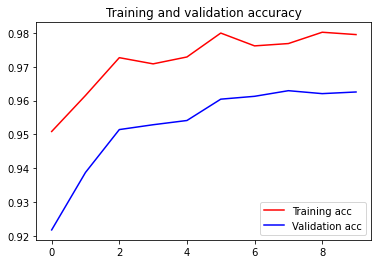

<Figure size 432x288 with 0 Axes>

In [ ]:
import json
import matplotlib.pyplot as plt

f = open("train_log/svhn-dorefa-1,2,4/stats_def_1.json","r")

data = json.load(f)
accuracy = []
val_accuracy = []
for ob in data:
  accuracy.append(ob["accuracy"])
  val_accuracy.append(ob["val_accuracy"])

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [8]:
from tabulate import tabulate
import matplotlib.pyplot as plt

ep = [i+1 for i in epochs]
table_acc = {"Epochs" : ep, "Accuracy":accuracy}
table_val_acc = {"Epochs" : ep, "Accuracy":val_accuracy}

print("ACCURACY\n")
print(tabulate(table_acc, headers='keys', tablefmt='fancy_grid'))
print("\nVALIDATION ACCURACY\n")
print(tabulate(table_val_acc, headers='keys', tablefmt='fancy_grid'))

ACCURACY

╒══════════╤════════════╕
│   Epochs │   Accuracy │
╞══════════╪════════════╡
│        1 │   0.950878 │
├──────────┼────────────┤
│        2 │   0.961502 │
├──────────┼────────────┤
│        3 │   0.972659 │
├──────────┼────────────┤
│        4 │   0.970831 │
├──────────┼────────────┤
│        5 │   0.972864 │
├──────────┼────────────┤
│        6 │   0.979916 │
├──────────┼────────────┤
│        7 │   0.976136 │
├──────────┼────────────┤
│        8 │   0.976823 │
├──────────┼────────────┤
│        9 │   0.98016  │
├──────────┼────────────┤
│       10 │   0.979471 │
╘══════════╧════════════╛

VALIDATION ACCURACY

╒══════════╤════════════╕
│   Epochs │   Accuracy │
╞══════════╪════════════╡
│        1 │   0.921837 │
├──────────┼────────────┤
│        2 │   0.938789 │
├──────────┼────────────┤
│        3 │   0.95144  │
├──────────┼────────────┤
│        4 │   0.95287  │
├──────────┼────────────┤
│        5 │   0.954121 │
├──────────┼────────────┤
│        6 │   0.960414 │
├─────